In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from helper_functions import plot_decision_boundary

try :
  import torchmetrics as torchm
except:
  ! pip install torchmetrics
  import torchmetrics as torchm

In [2]:
X, y = make_moons(n_samples = 1000, noise = 3e-2, random_state = 42)
X[:5], y[:5]

(array([[-0.00933187,  0.39098105],
        [ 0.95457387, -0.47375583],
        [ 0.9185256 , -0.42519648],
        [ 0.41276802, -0.37638459],
        [-0.84532016,  0.52879908]]),
 array([1, 1, 1, 1, 0]))

In [3]:
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

In [4]:
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

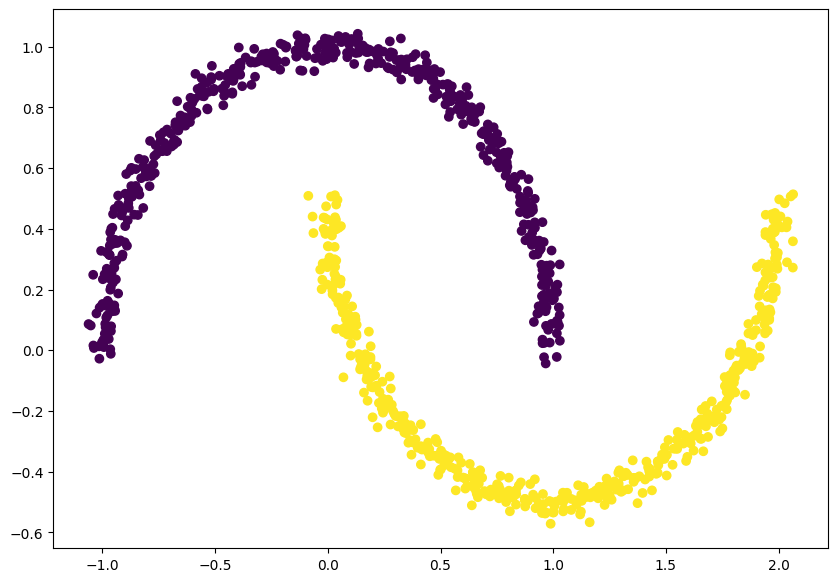

In [5]:
plt.figure(figsize = (10,7))
plt.scatter(X[:, 0], X[:, 1], c = y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
device

'cuda'

In [10]:
class MoonModelV0(nn.Module):
  def __init__(self, in_features, out_features, hidden_layers = 8):
    super().__init__()

    self.linear_stack = nn.Sequential(
        nn.Linear(in_features, hidden_layers),
        nn.ReLU(),
        nn.Linear(hidden_layers, hidden_layers),
        nn.ReLU(),
        nn.Linear(hidden_layers, out_features)
    )

  def forward(self, X: torch.tensor) -> torch.tensor:
    return self.linear_stack(X)

In [11]:
model = MoonModelV0(in_features = 2, out_features = 1).to(device)

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-1)

In [13]:
y_logits = model(X_train.to(device)).squeeze()

In [14]:
y_logits

tensor([-9.8849e-02, -1.3509e-02, -3.5453e-02, -3.4527e-02, -1.3608e-01,
        -2.0830e-02, -1.2841e-01, -1.0187e-01, -9.2609e-02, -1.8855e-02,
        -1.2262e-01, -5.6501e-02, -2.0510e-02, -7.8163e-02, -7.1395e-02,
        -9.1973e-03, -1.2071e-01, -2.4998e-02, -9.3152e-03, -1.0804e-01,
        -9.6160e-02, -8.8814e-02, -2.0158e-02, -7.2885e-02, -1.1103e-01,
        -1.0809e-01, -1.1822e-01, -8.8588e-02, -1.0296e-01, -1.0101e-01,
        -5.2044e-03, -1.3502e-01, -1.2894e-01, -9.1339e-02, -2.0689e-02,
        -1.0456e-01, -1.1923e-01, -1.0002e-01, -1.3204e-01, -1.3599e-01,
        -1.3188e-01, -7.2844e-02, -4.1737e-03, -7.3573e-02, -8.3076e-03,
        -8.8533e-02, -1.6466e-02, -1.2582e-01, -4.8620e-03,  1.7339e-03,
        -3.3360e-02, -1.2973e-01, -2.1336e-03, -1.1901e-01, -1.0005e-01,
        -1.3744e-01, -1.1964e-01, -9.3584e-02, -9.1494e-02, -1.2722e-01,
        -1.2051e-02, -1.2319e-01, -1.2552e-01, -8.5136e-02, -1.9288e-02,
        -1.3649e-01, -1.3380e-01, -6.2880e-02, -2.0

In [15]:
y_preds = torch.round(torch.sigmoid(y_logits))[:10]
y_preds

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [16]:
f1_fn = torchm.F1Score(task = 'binary', num_classes = 2).to(device)

In [17]:
f1_fn(y_preds, y_train[:10].to(device)).item() * 100

0.0

In [18]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model.train()

  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  f1_acc = f1_fn(y_pred, y_train).item() * 100

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()

  with torch.inference_mode():

    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_f1_acc = f1_fn(test_pred, y_test).item() * 100

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {f1_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_f1_acc:.2f}%")


Epoch: 0 | Loss: 0.70446, Acc: 0.00% | Test Loss: 0.70067, Test Acc: 0.00%
Epoch: 100 | Loss: 0.35474, Acc: 84.13% | Test Loss: 0.36680, Test Acc: 79.79%
Epoch: 200 | Loss: 0.22631, Acc: 89.45% | Test Loss: 0.22880, Test Acc: 90.82%
Epoch: 300 | Loss: 0.19360, Acc: 91.45% | Test Loss: 0.19616, Test Acc: 91.26%
Epoch: 400 | Loss: 0.16724, Acc: 92.10% | Test Loss: 0.16986, Test Acc: 91.63%
Epoch: 500 | Loss: 0.12850, Acc: 94.31% | Test Loss: 0.12849, Test Acc: 94.17%
Epoch: 600 | Loss: 0.08246, Acc: 97.53% | Test Loss: 0.07987, Test Acc: 98.02%
Epoch: 700 | Loss: 0.04837, Acc: 99.50% | Test Loss: 0.04562, Test Acc: 100.00%
Epoch: 800 | Loss: 0.02997, Acc: 100.00% | Test Loss: 0.02767, Test Acc: 100.00%
Epoch: 900 | Loss: 0.02034, Acc: 100.00% | Test Loss: 0.01848, Test Acc: 100.00%


In [19]:
model.eval()

with torch.inference_mode():
  y_logits = model(X_test).squeeze()

y_pred = torch.round(torch.sigmoid(y_logits))

In [20]:
print(f'F1Score: {f1_fn(y_pred, y_test).item() * 100}')

F1Score: 100.0


<ipython-input-21-47e350aed3bd>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
<ipython-input-21-47e350aed3bd>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)


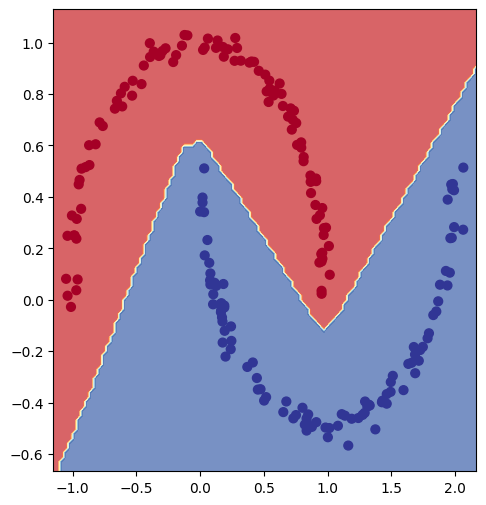

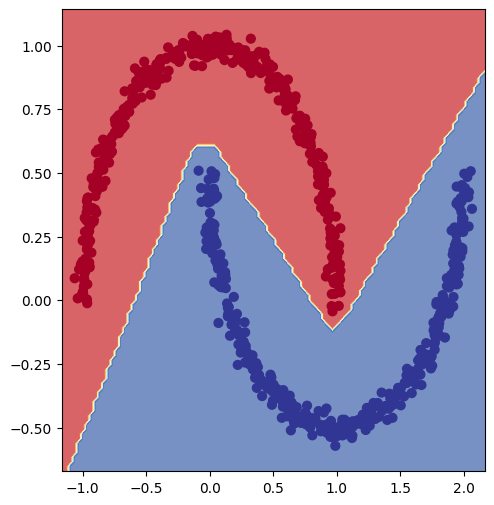

In [21]:
plt.figure(figsize = (12,6))
plt.title('Test')
plt.subplot(1,2,1)
plot_decision_boundary(model, X_test, y_test)
plt.figure(figsize = (12,6))
plt.title('Train')
plt.subplot(1,2,2)
plot_decision_boundary(model, X_train, y_train)

In [22]:
from pathlib import Path

MODEL_PATH = Path("/content/drive/MyDrive/Colab Notebooks/pytorch_tutorial/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "02_moon_best_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/MyDrive/Colab Notebooks/pytorch_tutorial/models/02_moon_best_model.pth
